## 0. Import modules and run an example of dummy_gym

In [1]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import *
import pickle
import time

# if there is a GPU available, set train the device to GPU
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Only I need to do this because I am running the code on my local machine
# os.chdir('/home/zhihan/ME5418')

# Create the environment instance
env = DummyGym()


2024-11-22 15:00:24.600827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 15:00:25.969606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-11-22 15:00:25.969727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No su

## 1. Parameters setting
In order to test our model, we did not assign large parameters. Set the training mode using one of the following options:
### Training Mode Options
- **`train`**: Start training from scratch, overwriting existing model, state, and replay buffer files.
- **`test`**: Test the model without overwriting any files.
- **`train_from_breakpoint`**: Continue training from the last saved breakpoint.
- **`fine_tune`**: Fine-tune the model while preserving the previous model.

In [2]:
# 断点文件会保存在train_breakpoint文件夹中
# 如果中途训练中断，可以从断点处继续训练，只需将train_mode设置为'train_from_breakpoint'，包括模型文件、状态文件和replay_buffer文件
# 如果想重新训练，将train_mode设置为'train'即可，模型文件、状态文件和replay_buffer文件会被覆盖
# 如果想测试模型，将train_mode设置为'test'即可，模型文件、状态文件和replay_buffer文件不会被覆盖
# 如果既想重新训练，又想保留之前的模型，即微调模型，将train_mode设置为'fine_tune'即可

train_mode = 'test'
# train_mode = 'train' # 'train' or 'test' or 'train_from_breakpoint' or 'fine_tune'
model_name = 'dqn_model.h5'
state_name = 'state.npz'
replay_buffer_name = 'replay_buffer.pkl'

breakpoint_path = 'train_breakpoint'
model_path = os.path.join(breakpoint_path, model_name)
state_path = os.path.join(breakpoint_path, state_name)
replay_buffer_path = os.path.join(breakpoint_path, replay_buffer_name)

# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 32 # 每次训练的数据量
n_episodes = 5 # 地图数量
time_steps = 1000 # 每张地图最多走多少步，避免陷入局部重复导致训练无效数据
epochs = 10 # 每个地图训练次数

# DQN parameters
gamma = 0.99  # discount rate, 0.99 means the future rewards are considered important
epsilon = 0.6 # 探索率
epsilon_min = 0.01 # 最小探索率
epsilon_decay = 0.995 # 探索衰减率

# Replay buffer
replay_buffer = deque(maxlen=2000) # 用于存储训练数据


action_size is 4


## 2. Processing states
The state we get from dummy_gym are lists and have only 2 dimensions. So we have to
1. Use `np.array` to change the type of state to `ndarray` for future data processing
2. Use `map.reshape((1, *map.shape, 1))` to reshape the state to 4 dimensions

In [3]:
# 处理原始state
def prepare_state(original_state):
    '''
    Prepare the state for the model by numpying and adding dimension
    '''
    new_state = []
    new_state_shape = []
    for state in original_state:
        state = np.array(state)
        # add dimension
        state = state.reshape(1, *state.shape, 1) # (30, 30) -> (1, 30, 30, 1)
        new_state.append(state)
        new_state_shape.append(state.shape)

    return new_state, new_state_shape

In [4]:
state, state_shape = prepare_state(original_state)
state_shape[0][1:]

(30, 30, 1)

## 3. Designing out model
After comparing different model output, we found that model behaves best when follows these settings:
1. `pool=True`
2. `dropout=True`
3. `residual=True`
4. `batch_norm=True`
5. `regularizer=None`

You can see the summay of the model in below ceil.\
**Model is loaded from `model_path` instead of being created if `train_mode` is set `fine_tune` or `train_from_breakpoint`**

In [5]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), activation='sigmoid', 
                     dense_units_1=64, dense_units_2=32, pool_size=(2,2), padding='same',
                     pool=True, dropout=True, residual=True, batch_norm=True, regularizer=None, LSTM=False, flat=True, dense_twice=True): # 多一个全连接多2000参数
                                                                                                                                           # 如果flat=False参数直接减少183万，但会丢失空间信息，因为GlobalAveragePooling2D会平均所有值
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0][1:], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding=padding)(input_visit_count_state)
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding=padding)(conv_visit_count_state)
    # print(conv_visit_count_state.shape)

    # different settings    
    batch_norm_visit_count_state = tf.keras.layers.BatchNormalization()(conv_visit_count_state) if batch_norm else conv_visit_count_state
    residual_visit_count_state = tf.keras.layers.Add()([input_visit_count_state, batch_norm_visit_count_state])     if residual else batch_norm_visit_count_state
    dropout_visit_count_state  = tf.keras.layers.Dropout(0.2)(residual_visit_count_state)                     if dropout  else residual_visit_count_state
    pool_visit_count_state     = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state) if pool     else dropout_visit_count_state
    
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1][1:], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding=padding)(input_fov_map)
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding=padding)(conv_fov_map)
    # print(conv_fov_map.shape)

    # different settings
    batch_norm_fov_map = tf.keras.layers.BatchNormalization()(conv_fov_map) if batch_norm else conv_fov_map
    residual_fov_map = tf.keras.layers.Add()([input_fov_map, batch_norm_fov_map]) if residual else batch_norm_fov_map
    dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(residual_fov_map) if dropout else residual_fov_map
    pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state) if pool else dropout_fov_map_state
    
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2][1:], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Add LSTM layer for sequential processing
    lstm_layer = tf.keras.layers.Reshape((1, combined.shape[1]))(combined)  # Reshape for LSTM input
    lstm_layer = tf.keras.layers.LSTM(64, activation=activation)(lstm_layer)  # LSTM layer added

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation=activation, kernel_regularizer=regularizer)(lstm_layer if LSTM else combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation=activation, kernel_regularizer=regularizer)(dense1) if dense_twice else dense1
    output = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=regularizer)(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
if train_mode == 'train_from_breakpoint' or train_mode == 'fine_tune' or train_mode == 'test':
    model = tf.keras.models.load_model(model_path)
    target_model = tf.keras.models.load_model(model_path)
elif train_mode == 'train':
    model = create_dqn_model()
    target_model = create_dqn_model()
    target_model.set_weights(model.get_weights())
else:
    raise ValueError('train_mode should be either train, test, fine_tune or train_from_breakpoint')
model.summary()

2024-11-22 15:00:27.585775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 30, 30, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 10, 10, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_2 (Conv2D)              (None, 10, 10, 16)   160         ['input_fov_map[0][0]']      

## 4. Select actions
Actions are selected randomly with the possibility of epsilon. Otherwise will be selected based on `q_values`.

In [6]:
def select_action(state, epsilon):
    '''
    Select action using epsilon-greedy policy
    '''
    if np.random.rand() <= epsilon:
        action = random.randrange(action_size)  # Explore: random action
        print(f'Ready to take random action:{action}')
    else:
#         env.render(map_type="visit_count")
        q_values = model.predict(state)  # Exploit: select action with max Q-value
        action_list = np.argsort(q_values[0])[::-1]
        action = action_list[0]
        print(f'Ready to take optimal action:{action} with q_values:{q_values}')
    
    return action  # Exploit: select action with max Q-value


## 5. Define function of trainnign model
1. **Sample a Minibatch**:
   - A minibatch of experiences is randomly sampled from the `replay_buffer` to train the model. Each experience is in the format `(state, action, reward, next_state, done)`.

2. **Loop through each Experience**:
   - The code iterates through each experience in the minibatch to update the model. 

3. **Initialize Target**:
   - The immediate reward is set as the initial target.

4. **Adjust Batch Dimension**:
   - This step ensures that the state tensors have a batch dimension (shape of 4D) by expanding dimensions if needed.

5. **Compute Target if Episode Not Done**:
   - If the episode is not finished (`done` is `False`), the target Q-value is updated using the formula:\
     $
     \text{target} = \text{reward} + \gamma \cdot \max_{a'} Q_{\text{target_model}}(\text{next_state}, a')
     $
   - `gamma` is the discount factor that weighs the contribution of future rewards. The target model is used to predict the Q-values of the next state.

6. **Update Predicted Q-Values**:
   - The current state's Q-values are predicted, and the Q-value for the action taken is updated with the calculated target value.

7. **Train the Model**:
   - The model is trained on the current state and updated Q-values for `epochs` iterations. The loss for each training step is stored in `history`.

8. **Plot Loss**:
   - This section plots the loss curve for the training steps within this minibatch.

9. **Update Target Model Weights**:
   - After training, the weights of the target model are updated to match the main model. This helps stabilize training by having a slightly outdated model (target model) to compare predictions.

10. **Return the Losses**:
    - The function returns the loss values for further analysis.

In [7]:
def train_dqn(batch_size): # learning agent
    with tf.device(device):
        minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
        for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据,32*avg_loss_decrease=64
            target = reward + gamma * np.amax(target_model.predict(next_state,verbose=0)[0])# 当前状态的reward作为target
            target_q_values = target_model.predict(state,verbose=0) # 得到4个动作的Q值
            target_q_values[0][action] = target # 将对应动作的Q值更新为target
            
            history = model.fit(state, target_q_values, epochs=epochs, verbose=0) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条

        # Update target model weights
        target_model.set_weights(model.get_weights())


## 6. Start tranning!
1. **Define saving and loading breakpoint function**:
   - In case of emergency like sudden death of kernel, function of saving and recovery should be defined.

2. **Loop Over Episodes**:
   - Iterates through a set number of episodes (`n_episodes`), each representing a complete run of the environment.

3. **Environment Reset**:
   - Resets the environment at the start of each episode and prepares the initial state.

4. **Loop Over Time Steps**:
   - Within each episode, it loops through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

5. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

6. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

7. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

8. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

9. **Check if Episode is Complete**:
   - Ends the episode if the `done` flag is set to `True` and prints the episode's result.

10. **Train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

11. **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.

In [8]:
def save_breakpoint():
    model.save(model_path)
    env.save_state(state_path)
    with open(replay_buffer_path, 'wb') as f:
        pickle.dump(replay_buffer, f)

def load_breakpoint():
    # Model already loaded
    with open(replay_buffer_path, 'rb') as f:
        replay_buffer = pickle.load(f)
    env.load_state(state_path)
    return replay_buffer

if train_mode=='train_from_breakpoint':
    replay_buffer = load_breakpoint()
    print('Loading model and replay buffer from breakpoint')
    env.render(map_type='visit_count')

In [9]:
# Train the model
if train_mode != 'test':
    for episode in range(n_episodes): # 训练多少张图
        print(f"\n********************Episode: {episode+1}/{n_episodes}********************")

        # Reset the environment and get the initial state
        state = env.state if train_mode== 'train_from_breakpoint' else env.reset()
        state,_ = prepare_state(state)
        epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
        replay_buffer = deque(maxlen=2000)
        images = []

        # Loop through each time step
        for time_step in range(time_steps): 
            print(f"\n-------------------Time step: {time_step}------------------------")
            images.append(env.visit_count / np.max(env.visit_count) * 255)
            # In each time step, agent selects an action and implement it, environment provides feedback
            action = select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            if done:
                env.render(map_type="visit_count")
                save_to_gif(images,'dqn_gif', f'policy_by_DQN_{time.strftime("%m-%d_%H-%M")}.gif')
                print("This eqisode is done, ready for next one.")
                break
            cells_visited = state[0][state[0] == EXPLORED].shape[0] # 计算已经访问的cell数量
            cells = env.map_size[0]*env.map_size[1]
            print(f"Cells visited: {cells_visited}/{env.map_size[0]*env.map_size[1]} at time step: {time_step}")
            print(f"Reward after this action:{reward}")

            # Store the data into replay buffer
            next_state,_ = prepare_state(next_state)
            replay_buffer.append((state, action, reward, next_state, done)) # 将数据存入replay buffer

            # Update state
            state = next_state

            # Train the model when replay buffer is larger than batch size
            if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
                print(f"Start training DQN model with batch size: {batch_size}")
                losses = train_dqn(batch_size)

                # If we are in train mode, save the gym, model and replay buffer for emergency stop every 100 time steps
                if (train_mode == 'train' or train_mode == 'fine_tune') and time_step % 50 == 0:
                    env.render(map_type="visit_count")
                    save_breakpoint()
                    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
                    print(f'epsilon is {epsilon}')
                    print(f"Model and replay buffer are saved under {breakpoint_path} at time step: {time_step}")

            # Otherwise, keep adding data to replay buffer
            else:
                print(f"Still adding data to replay buffer. Current replay buffer length: {len(replay_buffer)}")


## 7. Let's test!
1. **Environment Reset**:
   - Resets the environment and prepares the initial state. The environment is the same as training environment.
  
2. **Loop Over Time Steps**:
   - Loop through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

3. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

4. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

5. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

6. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

7.  **Test and train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

8.  **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.


-------------------Time step: 0------------------------
Ready to take random action:3
Car moves Right 3 units from (25, 5) to (25, 8)
Cells visited: 0/900 at time step: 0
Collision rate: 0/0

-------------------Time step: 1------------------------
1/1 [==============================] - 0s 107ms/step
Ready to take optimal action:2 with q_values:[[ -8.751141  -10.762853   -7.8785076  -8.763107 ]]
Car moves Left 3 units from (25, 8) to (25, 5)
Cells visited: 100/900 at time step: 1
Collision rate: 0/1

-------------------Time step: 2------------------------
Ready to take random action:1
Car moves Down 3 units from (25, 5) to (28, 5)
Cells visited: 130/900 at time step: 2
Collision rate: 0/2

-------------------Time step: 3------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 5) to (25, 5)
Cells visited: 130/900 at time step: 3
Collision rate: 0/3

-------------------Time step: 4------------------------
Ready to take random action:1
Car moves Down 3 units f


-------------------Time step: 35------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 2)
Cells visited: 232/900 at time step: 35
Collision rate: 13/35
Start training DQN model with batch size: 32

-------------------Time step: 36------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 2)
Cells visited: 232/900 at time step: 36
Collision rate: 14/36
Start training DQN model with batch size: 32

-------------------Time step: 37------------------------
Ready to take random action:1
Car moves Down 3 units from (13, 2) to (16, 2)
Cells visited: 232/900 at time step: 37
Collision rate: 14/37
Start training DQN model with batch size: 32

-------------------Time step: 38------------------------
1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-6.438986  -9.343675  -8.609418  -7.0497913]]
Car moves Up 3 units from (16, 2) to (13, 2)
Cells visited: 2

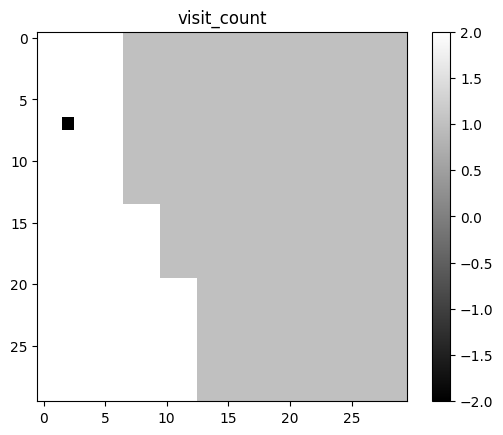


-------------------Time step: 51------------------------
1/1 [==============================] - 0s 14ms/step
Ready to take optimal action:0 with q_values:[[-0.5935428 -3.201303  -3.581358  -1.7767167]]
Car moves Up 3 units from (7, 2) to (4, 2)
Cells visited: 288/900 at time step: 51
Collision rate: 18/51
Start training DQN model with batch size: 32

-------------------Time step: 52------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 2) to (1, 2)
Cells visited: 288/900 at time step: 52
Collision rate: 18/52
Start training DQN model with batch size: 32

-------------------Time step: 53------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 2) to (1, 5)
Cells visited: 288/900 at time step: 53
Collision rate: 18/53
Start training DQN model with batch size: 32

-------------------Time step: 54------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 5) to (1, 8)
Cells visited: 306/900 at time ste

In [ ]:
# Test the model
if train_mode == 'test':
    # Reset the environment and get the initial state
    state = env.reset()
    state,_ = prepare_state(state)
    replay_buffer = deque(maxlen=2000)
    images = []
    titles = []
    collision_time = 0

    # Loop through each time step
    for time_step in range(time_steps): 
        print(f"\n-------------------Time step: {time_step}------------------------")

        # Prepare the images and titles for the gif
        combined_image = combine_all(env)
        images.append(combined_image / np.max(combined_image) * 255)
        titles.append(f"{time_step}")

        # In each time step, agent selects an action and implement it, environment provides feedback
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        if done:
            env.render(map_type="visit_count")
            save_to_gif(images,'test_dqn_gif', f'policy_by_DQN_fully_explored{time.strftime("%m-%d_%H-%M")}.gif', titles)
            print("ALL DONE")
            break

        # Calculate the number of cells visited
        cells_visited = state[0][state[0] == EXPLORED].shape[0]
        cells = env.map_size[0]*env.map_size[1]
        print(f"Cells visited: {cells_visited}/{env.map_size[0]*env.map_size[1]} at time step: {time_step}")

        # Collision rate
        collision_time = collision_time + 1 if env.COLLISION_FLAG else collision_time
        print(f"Collision rate: {collision_time}/{time_step}")

        # Store the data into replay buffer
        next_state,_ = prepare_state(next_state)
        replay_buffer.append((state, action, reward, next_state, done)) # 将数据存入replay buffer

        # Update state
        state = next_state

        # Training while testing
        if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
            print(f"Start training DQN model with batch size: {batch_size}")
            losses = train_dqn(batch_size)

            # if time_step % 3 == 0:
            #     save_to_gif(images,'test_dqn_gif', f'policy_by_DQN_{time.strftime("%m-%d_%H-%M")}.gif', titles)

            # If we are in train mode, save the gym, model and replay buffer for emergency stop every 100 time steps
            if time_step % 50 == 0:
                save_to_gif(images,'test_dqn_gif', f'policy_by_DQN_{time.strftime("%m-%d_%H-%M")}.gif', titles)
                env.render(map_type="visit_count")
                epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
